In [1]:
import pandas as pd
import seaborn as sns
from glob import glob
import matplotlib.pyplot as plt

In [2]:
# download and unzip performance logs dir
# comment this if not needed
# !wget https://www.dropbox.com/s/luqu9om98fmz6cf/performance_logs.zip?dl=1 -O performance_logs.zip
# !unzip performance_logs.zip

In [3]:
non_pandora_tools_to_dirnames={
    "snippy":                          "performance_logs/other_tools/medaka_samtools_snippy_logs/cluster/run_pe_snippy",
    "samtools":                        "performance_logs/other_tools/medaka_samtools_snippy_logs/cluster/samtools_mpileup_bcftools_call",
    "medaka":                          "performance_logs/other_tools/medaka_samtools_snippy_logs/cluster/run_medaka",
    "nanopolish":                      "performance_logs/other_tools/nanopolish_logs/cluster/run_nanopolish",
}
pandora_tools_to_dirnames={
    "pandora_illumina_20_way":                "performance_logs/pandora/logs_illumina_performance/cluster",
    "pandora_nanopore_20_way":                "performance_logs/pandora/logs_nanopore_performance/cluster",
    "pandora_illumina_1_way":  "performance_logs/pandora/logs_illumina_performance_single_sample/cluster",
    "pandora_nanopore_1_way":  "performance_logs/pandora/logs_nanopore_performance_single_sample/cluster",
}

In [4]:
def get_lines(cluster_log_file):
    with open(cluster_log_file) as cluster_log_filehandler:
        return [line.strip() for line in cluster_log_filehandler.readlines()]
def successfully_completed(cluster_log_file):
    lines = get_lines(cluster_log_file)
    return "Successfully completed." in lines



def get_field_from_log(cluster_log_file, field):
    lines = get_lines(cluster_log_file)
    for line in lines:
        if line.startswith(field):
            split_line = line.split()
            value_as_str = split_line[3]
            if value_as_str == "-":
                return 0.0
            else:
                return float(value_as_str)           
    assert False, f"Field not found: {field} in {cluster_log_file}"
    
    
def get_runtime(cluster_log_file):
    return get_field_from_log(cluster_log_file, "Run time") / 3600
def get_cputime(cluster_log_file):
    return get_field_from_log(cluster_log_file, "CPU time") / 36060
def get_max_memory(cluster_log_file):
    return get_field_from_log(cluster_log_file, "Max Memory") / 1024


In [5]:
# get non-pandora tool stats
non_pandora_tool_to_runtime_hours = {tool: [] for tool in non_pandora_tools_to_dirnames.keys()}
non_pandora_tool_to_cputime_hours = {tool: [] for tool in non_pandora_tools_to_dirnames.keys()}
non_pandora_tool_to_RAM_GB = {tool: [] for tool in non_pandora_tools_to_dirnames.keys()}

for tool, dirname in non_pandora_tools_to_dirnames.items():
    cluster_log_files = glob(f"{dirname}/*/*.out")

    for cluster_log_file in cluster_log_files:
        if successfully_completed(cluster_log_file):
            non_pandora_tool_to_runtime_hours[tool].append(get_runtime(cluster_log_file))
            non_pandora_tool_to_cputime_hours[tool].append(get_cputime(cluster_log_file))
            non_pandora_tool_to_RAM_GB[tool].append(get_max_memory(cluster_log_file))

    assert len(non_pandora_tool_to_runtime_hours[tool])==480
    assert len(non_pandora_tool_to_cputime_hours[tool])==480
    assert len(non_pandora_tool_to_RAM_GB[tool])==480

In [6]:
data_non_pandora={"Runtime in hours":[], "CPUtime in hours":[], "RAM in GB":[], "tool":[]}
for tool in non_pandora_tools_to_dirnames.keys():
    if "pandora" not in tool:
        data_non_pandora["Runtime in hours"].extend(non_pandora_tool_to_runtime_hours[tool])
        data_non_pandora["CPUtime in hours"].extend(non_pandora_tool_to_cputime_hours[tool])
        data_non_pandora["RAM in GB"].extend(non_pandora_tool_to_RAM_GB[tool])
        data_non_pandora["tool"].extend([tool] * 480)

df_non_pandora = pd.DataFrame(data=data_non_pandora)
df_non_pandora

,Runtime in hours,CPUtime in hours,RAM in GB,tool
0,0.089167,0.024930,2.833008,snippy
1,0.109167,0.028863,2.677734,snippy
2,0.125556,0.033386,2.980469,snippy
3,0.083611,0.021691,2.660156,snippy
4,0.096667,0.025546,1.537109,snippy
...,...,...,...,...
1915,6.493056,8.009088,8.632812,nanopolish
1916,5.215000,6.988367,8.355469,nanopolish
1917,12.253611,7.442955,7.250977,nanopolish
1918,2.608333,3.516801,6.161133,nanopolish


In [7]:
# get pandora tool stats
from collections import defaultdict
pandora_tool_to_rule_to_runtime_hours = {tool: defaultdict(list) for tool in pandora_tools_to_dirnames.keys()}
pandora_tool_to_rule_to_cputime_hours = {tool: defaultdict(list) for tool in pandora_tools_to_dirnames.keys()}
pandora_tool_to_rule_to_RAM_GB = {tool: defaultdict(list) for tool in pandora_tools_to_dirnames.keys()}

def is_an_interesting_pandora_logfile(cluster_log_file):
    return \
        ("compare_withdenovo" in cluster_log_file and "genotyping_mode=global" in cluster_log_file) or \
        "index_prg_updated_with_denovo_paths" in cluster_log_file or \
        "map_with_discovery" in cluster_log_file or \
        "run_clustalo_after_adding_MSA_path" in cluster_log_file or \
        "run_make_prg" in cluster_log_file

def get_rule_that_was_run(cluster_log_file):
    cluster_log_file_split = cluster_log_file.split("/")
    index_cluster = cluster_log_file_split.index("cluster")
    rule_that_was_run = cluster_log_file_split[index_cluster+1]
    return rule_that_was_run

def prettify_rule(rule):
    if rule == "map_with_discovery":
        return "map"
    elif rule == "run_clustalo_after_adding_MSA_path":
        return "clustalo"
    elif rule=="compare_withdenovo":
        return "compare"
    elif rule=="index_prg_updated_with_denovo_paths":
        return "index"
    elif rule=="run_make_prg":
        return "makeprg"
    else:
        assert False
   
    
for tool, dirname in pandora_tools_to_dirnames.items():
    if "pandora" in tool:
        cluster_log_files = glob(f"{dirname}/**/*.out", recursive=True)

        for cluster_log_file in cluster_log_files:
            if is_an_interesting_pandora_logfile(cluster_log_file) and successfully_completed(cluster_log_file):
                rule = get_rule_that_was_run(cluster_log_file)
                rule = prettify_rule(rule)
                pandora_tool_to_rule_to_runtime_hours[tool][rule].append(get_runtime(cluster_log_file))
                pandora_tool_to_rule_to_cputime_hours[tool][rule].append(get_cputime(cluster_log_file))
                pandora_tool_to_rule_to_RAM_GB[tool][rule].append(get_max_memory(cluster_log_file))



In [8]:
# summarises pandora_tool_to_rule_to_runtime_hours, pandora_tool_to_rule_to_cputime_hours and pandora_tool_to_rule_to_RAM_GB
pandora_tool_to_total_runtime = {tool: {} for tool in pandora_tools_to_dirnames.keys()}
for pandora_tool, rule_to_runtimes in pandora_tool_to_rule_to_runtime_hours.items():
    total = 0.0
    for rule, runtimes in rule_to_runtimes.items():
        pandora_tool_to_total_runtime[pandora_tool][rule] = sum(runtimes)
        total += sum(runtimes)
    pandora_tool_to_total_runtime[pandora_tool]["total"] = total
display(pandora_tool_to_total_runtime)


pandora_tool_to_total_cputime = {tool: {} for tool in pandora_tools_to_dirnames.keys()}
for pandora_tool, rule_to_cputimes in pandora_tool_to_rule_to_cputime_hours.items():
    total = 0.0
    for rule, cputimes in rule_to_cputimes.items():
        pandora_tool_to_total_cputime[pandora_tool][rule] = sum(cputimes)
        total += sum(cputimes)
    pandora_tool_to_total_cputime[pandora_tool]["total"] = total
display(pandora_tool_to_total_cputime)
    
pandora_tool_to_max_RAM_GB = {tool: {} for tool in pandora_tools_to_dirnames.keys()}
for pandora_tool, rule_to_RAM_GBs in pandora_tool_to_rule_to_RAM_GB.items():
    max_RAM_GB = 0.0
    for rule, RAM_GBs in rule_to_RAM_GBs.items():
        pandora_tool_to_max_RAM_GB[pandora_tool][rule] = max(RAM_GBs)
        max_RAM_GB = max(max(RAM_GBs), max_RAM_GB)
    pandora_tool_to_max_RAM_GB[pandora_tool]["max"] = max_RAM_GB
display(pandora_tool_to_max_RAM_GB)

{'pandora_illumina_20_way': {'map': 59.53111111111112,
  'clustalo': 1657.8016666666654,
  'compare': 27.782777777777778,
  'index': 2.4947222222222223,
  'makeprg': 2595.928333333343,
  'total': 4343.538611111119},
 'pandora_nanopore_20_way': {'map': 82.22277777777778,
  'clustalo': 1645.1800000000153,
  'compare': 45.92777777777778,
  'index': 2.3975,
  'makeprg': 2398.2122222222306,
  'total': 4173.940277777801},
 'pandora_illumina_1_way': {'map': 2.643611111111111,
  'clustalo': 85.88972222222195,
  'compare': 0.5880555555555556,
  'index': 3.2175,
  'makeprg': 35.08833333333335,
  'total': 127.42722222222197},
 'pandora_nanopore_1_way': {'map': 2.5405555555555557,
  'clustalo': 195.31722222222265,
  'compare': 0.7722222222222223,
  'index': 2.9955555555555557,
  'makeprg': 207.941111111111,
  'total': 409.566666666667}}

{'pandora_illumina_20_way': {'map': 21.237466999445363,
  'clustalo': 11.143485856905206,
  'compare': 15.515751525235718,
  'index': 2.527389628397116,
  'makeprg': 2.7343189129229213,
  'total': 53.15841292290633},
 'pandora_nanopore_20_way': {'map': 22.91250665557404,
  'clustalo': 13.559224625623933,
  'compare': 22.125384914032168,
  'index': 3.0651331114808653,
  'makeprg': 3.3980582362728766,
  'total': 65.06030754298389},
 'pandora_illumina_1_way': {'map': 0.9213904603438712,
  'clustalo': 7.77281752634499,
  'compare': 0.6210255130338325,
  'index': 2.6780585135884634,
  'makeprg': 1.0759059900166401,
  'total': 13.069198003327795},
 'pandora_nanopore_1_way': {'map': 0.8118513588463672,
  'clustalo': 7.99353466444814,
  'compare': 0.5731797004991681,
  'index': 2.4885235718247367,
  'makeprg': 1.1884242928452589,
  'total': 13.055513588463672}}

{'pandora_illumina_20_way': {'map': 10.314453125,
  'clustalo': 4.73828125,
  'compare': 10.7919921875,
  'index': 12.8486328125,
  'makeprg': 7.4345703125,
  'max': 12.8486328125},
 'pandora_nanopore_20_way': {'map': 10.708984375,
  'clustalo': 4.7978515625,
  'compare': 13.2587890625,
  'index': 13.7001953125,
  'makeprg': 49.6005859375,
  'max': 49.6005859375},
 'pandora_illumina_1_way': {'map': 9.2470703125,
  'clustalo': 3.24609375,
  'compare': 8.515625,
  'index': 12.6767578125,
  'makeprg': 3.333984375,
  'max': 12.6767578125},
 'pandora_nanopore_1_way': {'map': 7.4130859375,
  'clustalo': 3.7412109375,
  'compare': 6.9462890625,
  'index': 12.75390625,
  'makeprg': 3.8525390625,
  'max': 12.75390625}}

In [26]:
from datetime import datetime

pandora_tool_to_perceived_time_in_hours = {
    "pandora_illumina_20_way": (datetime(2020,10,5,13,48,48) - datetime(2020,10,3,17,16,33)).total_seconds()/3600,
    "pandora_nanopore_20_way": (datetime(2020,10,8,7,20,12) - datetime(2020,10,5,14,3,11)).total_seconds()/3600,
    "pandora_illumina_1_way": (datetime(2020,10,10,3,44,15) - datetime(2020,10,9,14,45,21)).total_seconds()/3600,
    "pandora_nanopore_1_way": (datetime(2020,10,12,21,22,13) - datetime(2020,10,12,11,21,28)).total_seconds()/3600,
}

pandora_tool_to_perceived_time_in_hours

{'pandora_illumina_20_way': 44.5375,
 'pandora_nanopore_20_way': 65.28361111111111,
 'pandora_illumina_1_way': 12.981666666666667,
 'pandora_nanopore_1_way': 10.0125}

Text(0, 0.5, 'Runtime in hours')

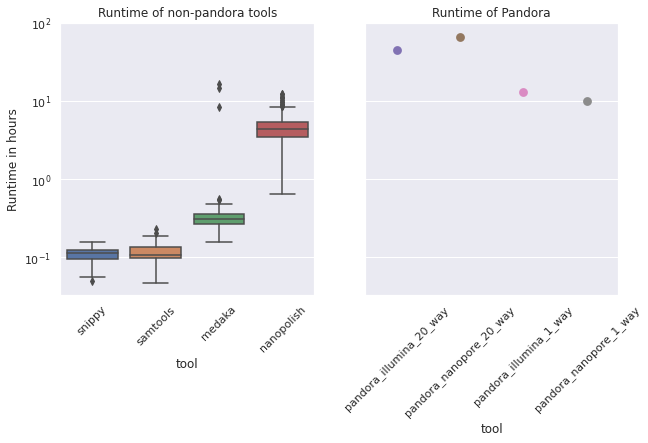

In [51]:
# plot the perceived time
# WARNING: to simplify, we are saying perceived time == runtime here!
df_non_pandora["Perceived time in hours"] = df_non_pandora["Runtime in hours"]
sns.set(rc={'figure.figsize':(10, 5)})
palette = sns.color_palette()
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plot = sns.boxplot(
    data=df_non_pandora[df_non_pandora["Perceived time in hours"] > 0.01],
    x="tool",
    y="Perceived time in hours",
    ax=ax1,
    palette=palette[:4]
)

pandora_df = pd.DataFrame(data={
    "Perceived time in hours": [pandora_tool_to_perceived_time_in_hours["pandora_illumina_20_way"],
                                pandora_tool_to_perceived_time_in_hours["pandora_nanopore_20_way"],
                                pandora_tool_to_perceived_time_in_hours["pandora_illumina_1_way"],
                                pandora_tool_to_perceived_time_in_hours["pandora_nanopore_1_way"]],
    "tool": ["pandora_illumina_20_way", "pandora_nanopore_20_way", "pandora_illumina_1_way", "pandora_nanopore_1_way"]
})
plot = sns.pointplot(
    data=pandora_df,
    x="tool",
    y="Perceived time in hours",
    ax=ax2,
    hue="tool",
    palette=palette[4:],
    legend=False
)
plot.set_yscale("log")
plot.set(ylim=(None, 100))
ax2.legend_.remove()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_title("Runtime of non-pandora tools")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_title("Runtime of Pandora")
ax2.set_ylabel('')
ax1.set_ylabel('Runtime in hours')

Text(0, 0.5, 'Runtime in hours')

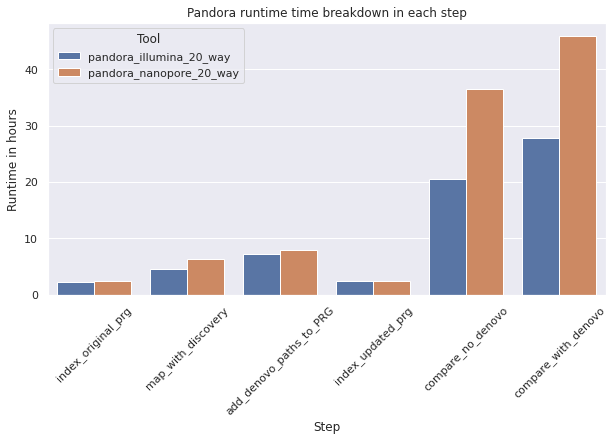

In [52]:
# plot the breakdown of perceived time
# WARNING: to simplify, we are saying perceived time == runtime here!

def date_strings_to_time_diff_in_hours(start_date_string, end_date_string):
    start_date_string = start_date_string[1:-1] # remove the brackets
    start_date = datetime.datetime.strptime(start_date_string, '%a %b %d %X %Y')
    end_date_string = end_date_string[1:-1] # remove the brackets
    end_date = datetime.datetime.strptime(end_date_string, '%a %b %d %X %Y')
    return (end_date - start_date).total_seconds()/3600
    
    

pandora_illumina_20_way_perceived_time_breakdown = pd.DataFrame(data={
    "Step": [
        "index_original_prg",
        "map_with_discovery",
        "add_denovo_paths_to_PRG",
        "index_updated_prg",
        "compare_no_denovo",
        "compare_with_denovo",
    ],
    "Perceived time in hours": [
        date_strings_to_time_diff_in_hours("[Sat Oct  3 17:16:33 2020]", "[Sat Oct  3 19:34:26 2020]"),
        date_strings_to_time_diff_in_hours("[Sat Oct  3 19:34:26 2020]", "[Sun Oct  4 00:03:30 2020]"),
        date_strings_to_time_diff_in_hours("[Sun Oct  4 00:09:50 2020]", "[Sun Oct  4 07:26:27 2020]"),
        date_strings_to_time_diff_in_hours("[Sun Oct  4 07:31:47 2020]", "[Sun Oct  4 10:01:34 2020]"),
        date_strings_to_time_diff_in_hours("[Sun Oct  4 07:32:48 2020]", "[Mon Oct  5 04:09:02 2020]"),
        date_strings_to_time_diff_in_hours("[Sun Oct  4 10:01:34 2020]", "[Mon Oct  5 13:48:48 2020]"),
    ],
    "Tool": ["pandora_illumina_20_way"] * 6
})


pandora_nanopore_20_way_perceived_time_breakdown = pd.DataFrame(data={
    "Step": [
        "index_original_prg",
        "map_with_discovery",
        "add_denovo_paths_to_PRG",
        "index_updated_prg",
        "compare_no_denovo",
        "compare_with_denovo",
    ],
    "Perceived time in hours": [
        date_strings_to_time_diff_in_hours("[Mon Oct  5 14:03:11 2020]", "[Mon Oct  5 16:31:46 2020]"),
        date_strings_to_time_diff_in_hours("[Mon Oct  5 16:31:46 2020]", "[Mon Oct  5 22:49:52 2020]"),
        date_strings_to_time_diff_in_hours("[Mon Oct  5 22:55:48 2020]", "[Tue Oct  6 06:55:08 2020]"),
        date_strings_to_time_diff_in_hours("[Tue Oct  6 06:59:57 2020]", "[Tue Oct  6 09:24:21 2020]"),
        date_strings_to_time_diff_in_hours("[Tue Oct  6 07:00:17 2020]", "[Wed Oct  7 19:30:10 2020]"),
        date_strings_to_time_diff_in_hours("[Tue Oct  6 09:24:21 2020]", "[Thu Oct  8 07:20:12 2020]"),
    ],
    "Tool": ["pandora_nanopore_20_way"] * 6
})


pandora_perceived_time_breakdown = pd.concat([
    pandora_illumina_20_way_perceived_time_breakdown,
    pandora_nanopore_20_way_perceived_time_breakdown
])

plot = sns.barplot(
    data=pandora_perceived_time_breakdown,
    x="Step",
    y="Perceived time in hours",
    hue="Tool",
)
plot.set_title("Pandora runtime time breakdown in each step")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.set_ylabel('Runtime in hours')

Text(0, 0.5, '')

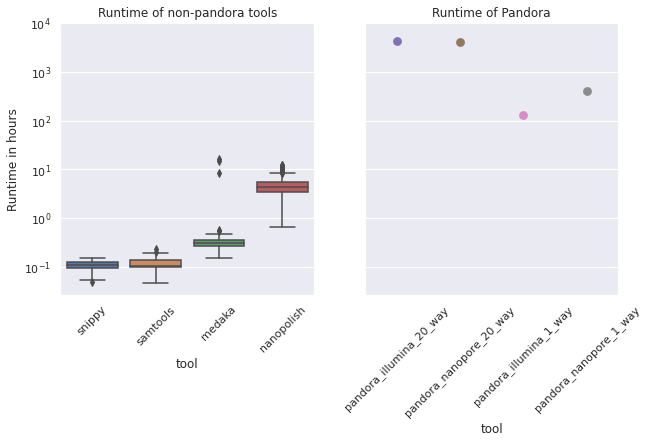

In [31]:
sns.set(rc={'figure.figsize':(10, 5)})
palette = sns.color_palette()
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plot = sns.boxplot(
    data=df_non_pandora[df_non_pandora["Runtime in hours"] > 0.01],
    x="tool",
    y="Runtime in hours",
    ax=ax1,
    palette=palette[:4]
)

pandora_df = pd.DataFrame(data={
    "Runtime in hours": [pandora_tool_to_total_runtime["pandora_illumina_20_way"]["total"],
                         pandora_tool_to_total_runtime["pandora_nanopore_20_way"]["total"],
                         pandora_tool_to_total_runtime["pandora_illumina_1_way"]["total"],
                         pandora_tool_to_total_runtime["pandora_nanopore_1_way"]["total"]],
    "tool": ["pandora_illumina_20_way", "pandora_nanopore_20_way", "pandora_illumina_1_way", "pandora_nanopore_1_way"]
})
plot = sns.pointplot(
    data=pandora_df,
    x="tool",
    y="Runtime in hours",
    ax=ax2,
    hue="tool",
    palette=palette[4:],
    legend=False
)
plot.set_yscale("log")
plot.set(ylim=(None, 10000))
ax2.legend_.remove()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_title("Runtime of non-pandora tools")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_title("Runtime of Pandora")
ax2.set_ylabel('')

Text(0, 0.5, '')

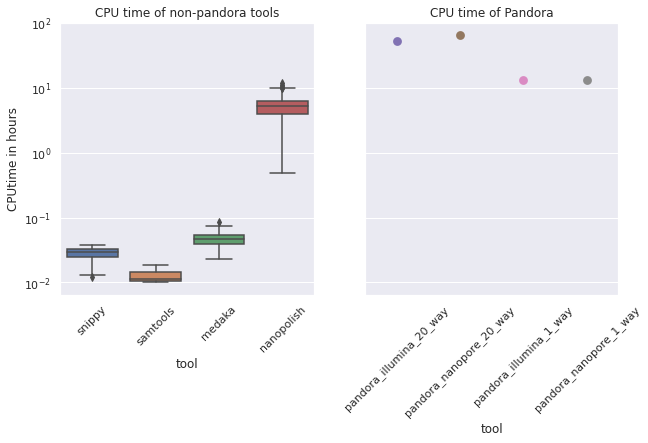

In [32]:
sns.set(rc={'figure.figsize':(10, 5)})
palette = sns.color_palette()
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plot = sns.boxplot(
    data=df_non_pandora[df_non_pandora["CPUtime in hours"] > 0.01],
    x="tool",
    y="CPUtime in hours",
    ax=ax1,
    palette=palette[:4]
)

pandora_df = pd.DataFrame(data={
    "CPUtime in hours": [pandora_tool_to_total_cputime["pandora_illumina_20_way"]["total"],
                         pandora_tool_to_total_cputime["pandora_nanopore_20_way"]["total"],
                         pandora_tool_to_total_cputime["pandora_illumina_1_way"]["total"],
                         pandora_tool_to_total_cputime["pandora_nanopore_1_way"]["total"]],
    "tool": ["pandora_illumina_20_way", "pandora_nanopore_20_way", "pandora_illumina_1_way", "pandora_nanopore_1_way"]
})
plot = sns.pointplot(
    data=pandora_df,
    x="tool",
    y="CPUtime in hours",
    ax=ax2,
    hue="tool",
    palette=palette[4:],
    legend=False
)
plot.set_yscale("log")
plot.set(ylim=(None, 100))
ax2.legend_.remove()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_title("CPU time of non-pandora tools")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_title("CPU time of Pandora")
ax2.set_ylabel('')

Text(0, 0.5, '')

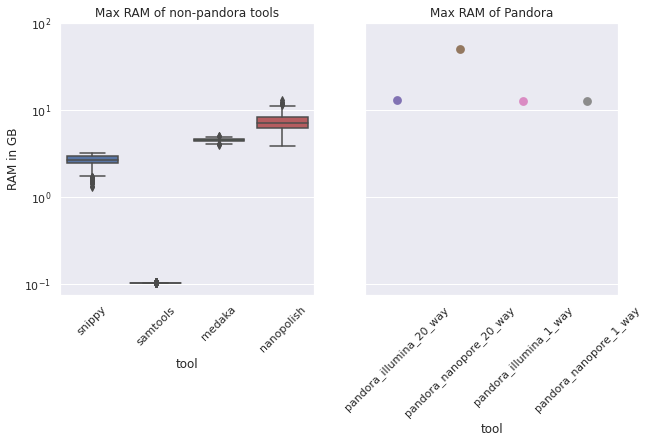

In [33]:
sns.set(rc={'figure.figsize':(10, 5)})
palette = sns.color_palette()
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
plot = sns.boxplot(
    data=df_non_pandora,
    x="tool",
    y="RAM in GB",
    ax=ax1,
    palette=palette[:4]
)

pandora_df = pd.DataFrame(data={
    "RAM in GB": [pandora_tool_to_max_RAM_GB["pandora_illumina_20_way"]["max"],
                  pandora_tool_to_max_RAM_GB["pandora_nanopore_20_way"]["max"],
                  pandora_tool_to_max_RAM_GB["pandora_illumina_1_way"]["max"],
                  pandora_tool_to_max_RAM_GB["pandora_nanopore_1_way"]["max"]],
    "tool": ["pandora_illumina_20_way", "pandora_nanopore_20_way", "pandora_illumina_1_way", "pandora_nanopore_1_way"]
})
plot = sns.pointplot(
    data=pandora_df,
    x="tool",
    y="RAM in GB",
    ax=ax2,
    hue="tool",
    palette=palette[4:],
    legend=False
)
plot.set_yscale("log")
plot.set(ylim=(None, 100))
ax2.legend_.remove()
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
ax1.set_title("Max RAM of non-pandora tools")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
ax2.set_title("Max RAM of Pandora")
ax2.set_ylabel('')

In [ ]:
pandora_runtime_df_grouped = pandora_runtime_df.groupby(by=["Step", "Tool"]).agg(sum).reset_index()
plot = sns.barplot(
    data=pandora_runtime_df_grouped,
    x="Step",
    y="Runtime in hours",
    hue="Tool",
)
plot.set_title("Pandora Runtime consumption in each step")

Text(0.5, 1.0, 'Breakdown of Pandora Runtime consumption in each step')

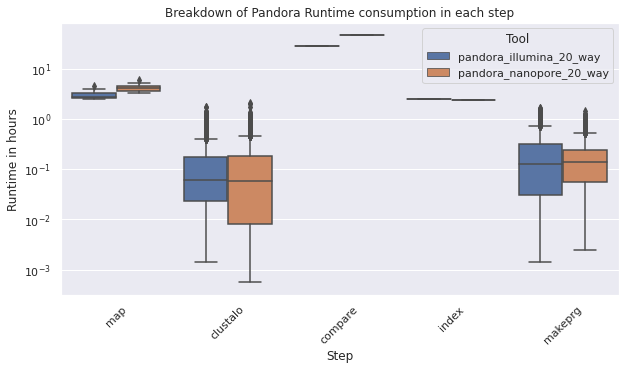

In [16]:
sns.set(rc={'figure.figsize':(10, 5)})

tool_list = []
rule_list = []
runtime_list = []
for pandora_tool, rule_to_runtimes in pandora_tool_to_rule_to_runtime_hours.items():
    if "20_way" in pandora_tool:
        for rule, runtimes in rule_to_runtimes.items():
            for runtime in runtimes:
                tool_list.append(pandora_tool)
                rule_list.append(rule)
                runtime_list.append(runtime)

pandora_runtime_df = pd.DataFrame(data = {
    "Tool": tool_list,
    "Step": rule_list,
    "Runtime in hours": runtime_list
}
)

plot = sns.boxplot(
    data=pandora_runtime_df,
    x="Step",
    y="Runtime in hours",
    hue="Tool",
)
plot.set_yscale("log")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.set_title("Breakdown of Pandora Runtime consumption in each step")

Text(0.5, 1.0, 'Pandora Runtime consumption in each step')

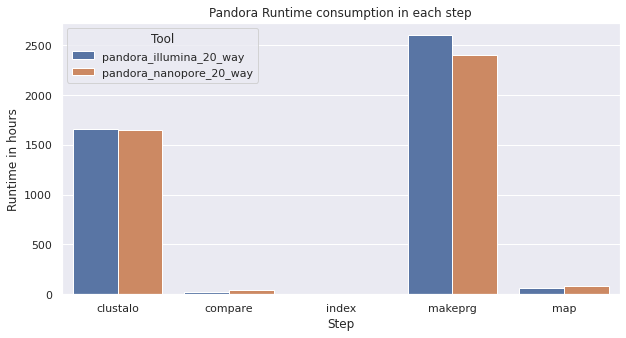

In [17]:
pandora_runtime_df_grouped = pandora_runtime_df.groupby(by=["Step", "Tool"]).agg(sum).reset_index()
plot = sns.barplot(
    data=pandora_runtime_df_grouped,
    x="Step",
    y="Runtime in hours",
    hue="Tool",
)
plot.set_title("Pandora Runtime consumption in each step")

Text(0.5, 1.0, 'Breakdown of Pandora CPU time consumption in each step')

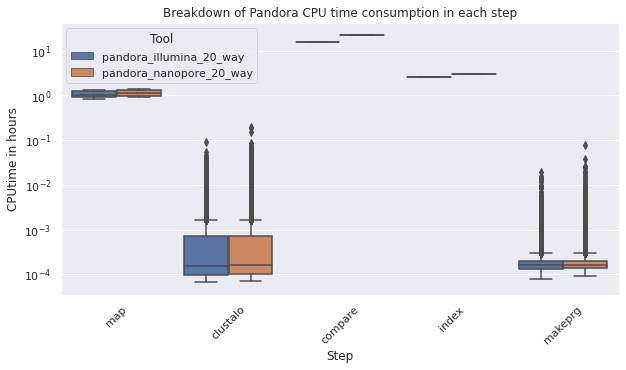

In [12]:
sns.set(rc={'figure.figsize':(10, 5)})

tool_list = []
rule_list = []
cputime_list = []
for pandora_tool, rule_to_cputimes in pandora_tool_to_rule_to_cputime_hours.items():
    if "20_way" in pandora_tool:
        for rule, cputimes in rule_to_cputimes.items():
            for cputime in cputimes:
                tool_list.append(pandora_tool)
                rule_list.append(rule)
                cputime_list.append(cputime)

pandora_cputime_df = pd.DataFrame(data = {
    "Tool": tool_list,
    "Step": rule_list,
    "CPUtime in hours": cputime_list
}
)

plot = sns.boxplot(
    data=pandora_cputime_df,
    x="Step",
    y="CPUtime in hours",
    hue="Tool",
)
plot.set_yscale("log")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.set_title("Breakdown of Pandora CPU time consumption in each step")

Text(0.5, 1.0, 'Pandora CPU time consumption in each step')

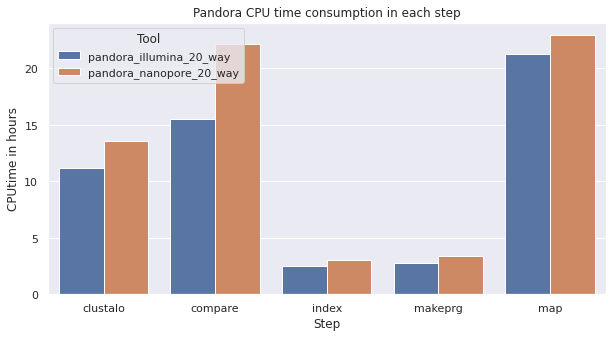

In [13]:
pandora_cputime_df_grouped = pandora_cputime_df.groupby(by=["Step", "Tool"]).agg(sum).reset_index()
plot = sns.barplot(
    data=pandora_cputime_df_grouped,
    x="Step",
    y="CPUtime in hours",
    hue="Tool",
)
plot.set_title("Pandora CPU time consumption in each step")

Text(0.5, 1.0, 'Breakdown of Pandora RAM consumption in each step')

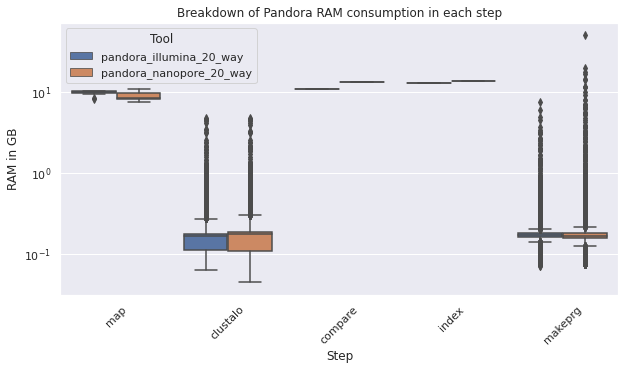

In [14]:
sns.set(rc={'figure.figsize':(10, 5)})

tool_list = []
rule_list = []
RAM_GB_list = []
for pandora_tool, rule_to_RAM_GBs in pandora_tool_to_rule_to_RAM_GB.items():
    if "20_way" in pandora_tool:
        for rule, RAM_GBs in rule_to_RAM_GBs.items():
            for RAM_GB in RAM_GBs:
                tool_list.append(pandora_tool)
                rule_list.append(rule)
                RAM_GB_list.append(RAM_GB)

pandora_RAM_GB_df = pd.DataFrame(data = {
    "Tool": tool_list,
    "Step": rule_list,
    "RAM in GB": RAM_GB_list
}
)

plot = sns.boxplot(
    data=pandora_RAM_GB_df,
    x="Step",
    y="RAM in GB",
    hue="Tool",
)
plot.set_yscale("log")
plot.set_xticklabels(plot.get_xticklabels(), rotation=45)
plot.set_title("Breakdown of Pandora RAM consumption in each step")

Text(0.5, 1.0, 'Pandora max RAM consumption in each step')

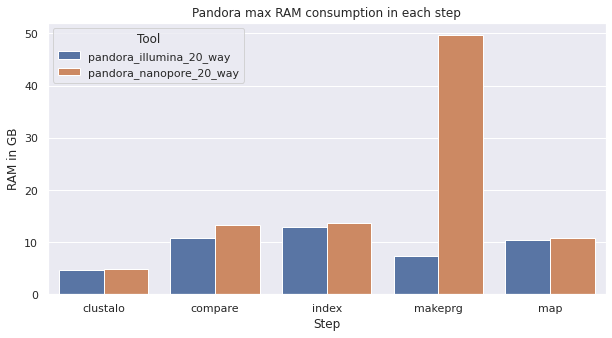

In [15]:
pandora_RAM_GB_df_grouped = pandora_RAM_GB_df.groupby(by=["Step", "Tool"]).agg(max).reset_index()
plot = sns.barplot(
    data=pandora_RAM_GB_df_grouped,
    x="Step",
    y="RAM in GB",
    hue="Tool",
)
plot.set_title("Pandora max RAM consumption in each step")